In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import csv
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.ticker as ticker

In [2]:
r = pd.read_csv("rmsg_comm.csv")
r

/tmp/ipykernel_25257/956506028.py:1: DtypeWarning: Columns (27,30) have mixed types. Specify dtype option on import or set low_memory=False.
  r = pd.read_csv("rmsg_comm.csv")


,chat_id,id,chat_name,peer_id,messagedatetime,messagedate,messagetext,out,mentioned,media_unread,...,post_author,grouped_id,ttl_period,quick_reply_shortcut_id,effect,factcheck,views,forwards,replies,reactions
0,1872871388,4988378,https://t.me/specchatZ,1872871388,2024-12-08 11:00:06,2024-12-08,Гнида приехала лизать дупу трампу,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
1,1872871388,4988380,https://t.me/specchatZ,1872871388,2024-12-08 11:00:55,2024-12-08,"Да, как все быстро устроили🙈🙈🙈🙈",f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2,1872871388,4988384,https://t.me/specchatZ,1872871388,2024-12-08 11:01:13,2024-12-08,⚡️ Правила чата:\n\n⚠️ Ссылки и пересылки из д...,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3,1872871388,4988385,https://t.me/specchatZ,1872871388,2024-12-08 11:02:02,2024-12-08,Смирись и прими!\nКаждому своё время!,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
4,1872871388,4988386,https://t.me/specchatZ,1872871388,2024-12-08 11:02:05,2024-12-08,Украину давно желают🙈🙈🙈🙈😡😡😡,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048941,1366415996,19037272,https://t.me/readovchat,1366415996,2024-12-16 09:16:14,2024-12-16,"Раньше отстреливали всех и все, зверье зало, ч...",f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3048942,1366415996,19037278,https://t.me/readovchat,1366415996,2024-12-16 09:16:27,2024-12-16,"Знаю несколько пар, которые не заводят детей т...",f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,"{""👍"": 1}"
3048943,1366415996,19037285,https://t.me/readovchat,1366415996,2024-12-16 09:16:38,2024-12-16,Жилищный вопрос - это только часть проблемы. Я...,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,"{""❤"": 2, ""🤯"": 1}"
3048944,1366415996,19037298,https://t.me/readovchat,1366415996,2024-12-16 09:17:30,2024-12-16,Но от таджиков и негров рожают. Значит нашим м...,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN


In [3]:
def organize_threads(csv_file_path):
    # First pass: read all messages and create message lookup
    messages = {}
    roots = []

    with open(csv_file_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            msg_id = row['id']
            chat_id = row['chat_id']
            reply_to = row['reply_to']

            # Create composite key using both chat_id and msg_id
            msg_key = f"{chat_id}_{msg_id}"

            messages[msg_key] = {
                'data': row,
                'children': []
            }

            # If it's a root message (no reply_to)
            if not reply_to:
                roots.append(msg_key)

    # Second pass: build threads by connecting replies
    for msg_key, msg_data in messages.items():
        reply_to = msg_data['data']['reply_to']
        chat_id = msg_data['data']['chat_id']

        if reply_to:
            # Create parent message key using the same chat_id
            parent_key = f"{chat_id}_{reply_to}"
            if parent_key in messages:
                messages[parent_key]['children'].append(msg_key)

    # Helper function to flatten a thread
    def flatten_thread(msg_key):
        thread = [messages[msg_key]['data']]
        for child_key in messages[msg_key]['children']:
            thread.extend(flatten_thread(child_key))
        return thread

    # Build final list of threads
    threads = []
    for root_key in roots:
        thread = flatten_thread(root_key)
        threads.append(thread)

    return threads


In [4]:
threads = organize_threads('rmsg_comm.csv')

In [5]:
def create_thread_summary_df_optimized(threads):
    thread_summaries = []

    for thread in threads:
        if not thread:
            continue

        root_message = thread[0]
        root_id = root_message['id']

        # Create a message lookup dictionary for this thread
        msg_depths = {root_id: 0}  # Root has depth 0
        max_depth = 0

        # Single pass through messages to calculate depths
        for msg in thread[1:]:  # Skip root message
            reply_to = msg['reply_to']
            if reply_to in msg_depths:
                depth = msg_depths[reply_to] + 1
                msg_depths[msg['id']] = depth
                max_depth = max(max_depth, depth)

        thread_summary = {
            'root_id': root_id,
            'messagetext': root_message.get('messagetext', ''),
            'chat_name': root_message.get('chat_name', ''),
            'thread_size': len(thread),
            'max_depth': max_depth
        }
        thread_summaries.append(thread_summary)

    return pd.DataFrame(thread_summaries)

In [6]:
df = create_thread_summary_df_optimized(threads)
df = df.sort_values('thread_size', ascending=False)
df

,root_id,messagetext,chat_name,thread_size,max_depth
262539,18081366,На М-12 водитель фуры резко перестроился в лев...,https://t.me/readovchat,2777,33
341869,18926209,В Дзержинске школьницы дважды впечатали учител...,https://t.me/readovchat,2489,22
262435,18048844,Жители Химок несколько лет терпят запах гнили ...,https://t.me/readovchat,2437,10
202558,18259811,Проректор Финансового Университета Зубец предл...,https://t.me/readovchat,2266,21
341801,18900319,"Тот самый 14-летний чеченец, за которого накан...",https://t.me/readovchat,2255,26
...,...,...,...,...,...
17,4989729,Полная Нассрала,https://t.me/specchatZ,1,0
16,4989705,"Pondok Indah, вам повышена репутация!🌟\nСейчас...",https://t.me/specchatZ,1,0
14,4994324,"Alesia Astaxova, вам повышена репутация!🌟\nСей...",https://t.me/specchatZ,1,0
13,4989727,Кто насрал,https://t.me/specchatZ,1,0


In [7]:
def plot_thread_density_simple(thread, interval_minutes=10):
    # Clear any existing plots
    plt.clf()

    df = pd.DataFrame(thread)
    df['timestamp'] = pd.to_datetime(df['messagedatetime'])

    counts = df.resample(f'{interval_minutes}min', on='timestamp').size()

    # Create a new figure
    fig = plt.figure(figsize=(15, 7))

    plt.plot(counts.index, counts.values, '-', linewidth=2)

    plt.title(f'Comment Density Over Time\n'
              f'Thread started: {df.timestamp.min().strftime("%Y-%m-%d %H:%M:%S")}\n'
              f'Total messages: {len(thread)}, Interval: {interval_minutes} minutes')

    plt.xlabel('Time')
    plt.ylabel('Number of comments')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()

    # Close the figure to prevent display
    plt.close()

    return fig

In [8]:
sorted_threads = sorted(threads, key=len, reverse=True)

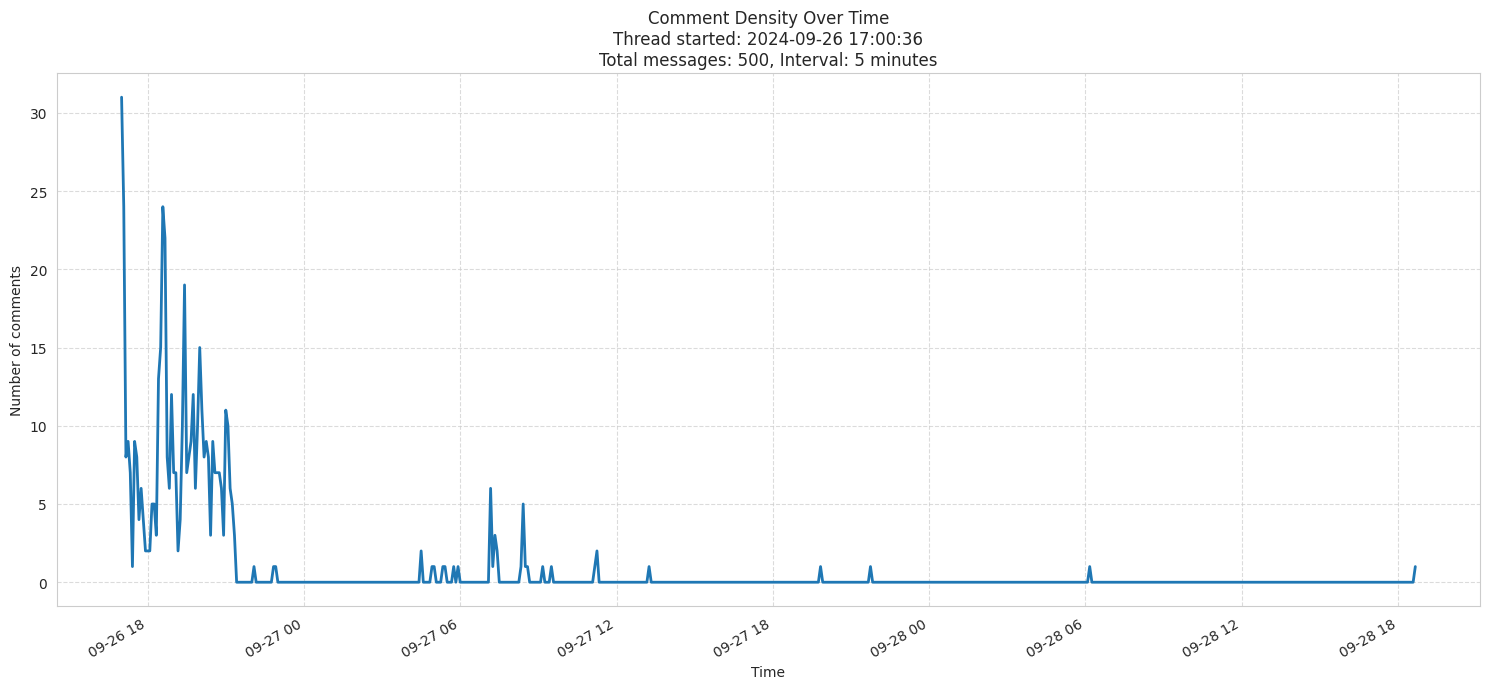

<Figure size 640x480 with 0 Axes>

In [9]:
fig = plot_thread_density_simple(sorted_threads[0][:500], interval_minutes=5)
fig

In [10]:
len(threads[0])

50

In [11]:
def flatten_threads_to_df(threads):
    flat_messages = []
    
    for thread in threads:
        if not thread:
            continue
            
        root_msg = thread[0]
        root_msg_id = root_msg['id']
        root_msg_key = f"{root_msg['chat_id']}_{root_msg['id']}"
        
        for msg in thread:
            msg_dict = msg.copy()
            msg_dict['root_msg_id'] = int(root_msg_id)
            msg_dict['root_msg_key'] = root_msg_key
            flat_messages.append(msg_dict)
    
    # Convert to DataFrame
    df = pd.DataFrame(flat_messages)
    
    # Convert datetime and sort
    df['messagedatetime'] = pd.to_datetime(df['messagedatetime'])
    df = df.sort_values('messagedatetime')
    
    return df

In [12]:
flattened = flatten_threads_to_df(threads)
flattened

,chat_id,id,chat_name,peer_id,messagedatetime,messagedate,messagetext,out,mentioned,media_unread,...,ttl_period,quick_reply_shortcut_id,effect,factcheck,views,forwards,replies,reactions,root_msg_id,root_msg_key
422308,1425154261,9257,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 00:30:21,2021-01-01,С Новым Годом 🎆,f,f,f,...,,,,,4049,5,1,,9257,1425154261_9257
422309,1425154261,9260,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 02:25:55,2021-01-01,Супер,f,f,f,...,,,,,0,0,0,,9257,1425154261_9257
422310,1425154261,9261,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 03:24:14,2021-01-01,https://vk.com/wall-61492440_772195,f,f,f,...,,,,,4066,1,6,,9261,1425154261_9261
422311,1425154261,9264,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 03:35:29,2021-01-01,👍,f,f,f,...,,,,,0,0,0,,9261,1425154261_9261
422312,1425154261,9265,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 03:40:17,2021-01-01,👍👍,f,f,f,...,,,,,0,0,0,,9261,1425154261_9261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918936,1366415996,19037325,https://t.me/readovchat,1366415996,2024-12-16 09:19:38,2024-12-16,Огромное уважение Бастрыкину!!!,f,f,f,...,,,,,0,0,0,,19037203,1366415996_19037203
1918937,1366415996,19037326,https://t.me/readovchat,1366415996,2024-12-16 09:19:41,2024-12-16,В расход этих чурок!,f,f,f,...,,,,,0,0,0,,19037203,1366415996_19037203
89956,1366415996,19037327,https://t.me/readovchat,1366415996,2024-12-16 09:19:45,2024-12-16,А давайте в честь «дня конституции» перепишем ...,f,f,f,...,,,,,0,0,0,,18998486,1366415996_18998486
1918868,1366415996,19037328,https://t.me/readovchat,1366415996,2024-12-16 09:19:55,2024-12-16,Капитализм для России это её закат.,f,f,f,...,,,,,0,0,0,,19036851,1366415996_19036851


In [13]:
classified_comm = pd.read_csv("msg_comm.csv")
classified_comm

,id,messagetext,chat_id,chat_name,messagedatetime,denazificationofukraine_similarity,protectionofrussianspeakers_similarity,natoexpansionthreat_similarity,biolabsconspiracy_similarity,ukraineasafailedstate_similarity,historicalunityofrussiaandukraine_similarity,westernrussophobia_similarity,sanctionsaseconomicwarfare_similarity,legitimizationofannexedterritories_similarity,discreditingukrainianleadership_similarity
0,932,Кировский район - сообщают о прилетах. \nПодро...,1759624775,https://t.me/svodkadnrr,2022-05-10 07:22:24,0.363518,0.412733,0.379205,0.403658,0.313252,0.359169,0.295160,0.318650,0.406319,0.344065
1,934,Сообщают о попадании в 14-этажку на Текстильщи...,1759624775,https://t.me/svodkadnrr,2022-05-10 07:30:59,0.278069,0.319513,0.280388,0.342343,0.313447,0.292393,0.279550,0.313060,0.222745,0.288536
2,935,Еще фото с Текстильщика\n\nПодписаться на ново...,1759624775,https://t.me/svodkadnrr,2022-05-10 07:34:04,0.350864,0.333533,0.299367,0.328005,0.344438,0.317094,0.287007,0.345397,0.313375,0.360459
3,939,Фото более лучшего качества\n\nПодписаться на ...,1759624775,https://t.me/svodkadnrr,2022-05-10 07:40:45,0.358291,0.352816,0.347029,0.366997,0.350818,0.333356,0.321616,0.346255,0.327540,0.376537
4,942,После обстрела вновь горит рынок.\n\nПодписать...,1759624775,https://t.me/svodkadnrr,2022-05-10 07:42:47,0.382616,0.365554,0.322637,0.337853,0.357958,0.298005,0.306774,0.387792,0.347808,0.364824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614411,922,"Здравствуйте, как с пешой очередью сегодня на ...",1781039971,https://t.me/kpp_granica_Donbass_Russia,2022-03-30 05:25:42,0.247597,0.226825,0.265796,0.258914,0.258335,0.267445,0.246913,0.244302,0.192740,0.264145
2614412,925,Ночью было нанесено несколько ракетных ударов ...,1759624775,https://t.me/svodkadnrr,2022-05-10 05:52:01,0.436001,0.470060,0.414805,0.438662,0.395387,0.354262,0.366362,0.417695,0.292731,0.428731
2614413,928,А как чужой по сути человек мог взять кредит н...,1781039971,https://t.me/kpp_granica_Donbass_Russia,2022-03-30 06:26:14,0.274786,0.248637,0.267289,0.296820,0.266521,0.252125,0.321180,0.289524,0.234644,0.312083
2614414,929,За сутки из Мариуполя эвакуированы 400 человек...,1759624775,https://t.me/svodkadnrr,2022-05-10 06:48:18,0.341952,0.316086,0.249141,0.286218,0.330619,0.225762,0.217861,0.193487,0.237640,0.276436


In [14]:
# First ensure the join columns are of the same type in both dataframes
flattened['chat_id'] = flattened['chat_id'].astype('Int64')
flattened['id'] = flattened['id'].astype('Int64')
flattened['root_msg_id'] = flattened['root_msg_id'].astype('Int64')
classified_comm['chat_id'] = classified_comm['chat_id'].astype('Int64')
classified_comm['id'] = classified_comm['id'].astype('Int64')

# Perform the merge for replies with specific handling of duplicate columns
joined_df = flattened.merge(
    classified_comm,
    left_on=['chat_id', 'root_msg_id'],
    right_on=['chat_id', 'id'],
    how='left',
    suffixes=('', '_y')  # keep left table column names, add _y to right table duplicates
)

# Drop the duplicate columns with _y suffix (as we want to keep the original columns)
duplicate_cols = [col for col in joined_df.columns if col.endswith('_y')]
joined_df = joined_df.drop(columns=duplicate_cols)

In [15]:
joined_df

,chat_id,id,chat_name,peer_id,messagedatetime,messagedate,messagetext,out,mentioned,media_unread,...,denazificationofukraine_similarity,protectionofrussianspeakers_similarity,natoexpansionthreat_similarity,biolabsconspiracy_similarity,ukraineasafailedstate_similarity,historicalunityofrussiaandukraine_similarity,westernrussophobia_similarity,sanctionsaseconomicwarfare_similarity,legitimizationofannexedterritories_similarity,discreditingukrainianleadership_similarity
0,1425154261,9257,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 00:30:21,2021-01-01,С Новым Годом 🎆,f,f,f,...,0.248484,0.238593,0.258281,0.262504,0.297790,0.304303,0.279074,0.289715,0.278389,0.252699
1,1425154261,9260,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 02:25:55,2021-01-01,Супер,f,f,f,...,0.248484,0.238593,0.258281,0.262504,0.297790,0.304303,0.279074,0.289715,0.278389,0.252699
2,1425154261,9261,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 03:24:14,2021-01-01,https://vk.com/wall-61492440_772195,f,f,f,...,0.352747,0.339243,0.324333,0.411720,0.354364,0.367370,0.398487,0.344885,0.314726,0.346028
3,1425154261,9264,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 03:35:29,2021-01-01,👍,f,f,f,...,0.352747,0.339243,0.324333,0.411720,0.354364,0.367370,0.398487,0.344885,0.314726,0.346028
4,1425154261,9265,https://t.me/incident_kuzbass_chat,1425154261,2021-01-01 03:40:17,2021-01-01,👍👍,f,f,f,...,0.352747,0.339243,0.324333,0.411720,0.354364,0.367370,0.398487,0.344885,0.314726,0.346028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918935,1366415996,19037325,https://t.me/readovchat,1366415996,2024-12-16 09:19:38,2024-12-16,Огромное уважение Бастрыкину!!!,f,f,f,...,0.523125,0.438542,0.422893,0.460579,0.441534,0.385835,0.419815,0.397494,0.418509,0.477528
1918936,1366415996,19037326,https://t.me/readovchat,1366415996,2024-12-16 09:19:41,2024-12-16,В расход этих чурок!,f,f,f,...,0.523125,0.438542,0.422893,0.460579,0.441534,0.385835,0.419815,0.397494,0.418509,0.477528
1918937,1366415996,19037327,https://t.me/readovchat,1366415996,2024-12-16 09:19:45,2024-12-16,А давайте в честь «дня конституции» перепишем ...,f,f,f,...,0.331993,0.345232,0.454705,0.384908,0.423526,0.475257,0.432255,0.370228,0.504351,0.352893
1918938,1366415996,19037328,https://t.me/readovchat,1366415996,2024-12-16 09:19:55,2024-12-16,Капитализм для России это её закат.,f,f,f,...,0.298019,0.320316,0.373239,0.329573,0.364779,0.335376,0.391228,0.335410,0.345269,0.308118


In [29]:
narratives = ["denazificationofukraine_similarity", "protectionofrussianspeakers_similarity", "natoexpansionthreat_similarity", "biolabsconspiracy_similarity", "ukraineasafailedstate_similarity",
              "historicalunityofrussiaandukraine_similarity", "westernrussophobia_similarity", "sanctionsaseconomicwarfare_similarity", "legitimizationofannexedterritories_similarity", "discreditingukrainianleadership_similarity"]

In [41]:
densities = []
for narrative in narratives:
    density = joined_df.resample(f'5min', on='messagedatetime').agg({narrative: 'mean'})
    densities.append(density)

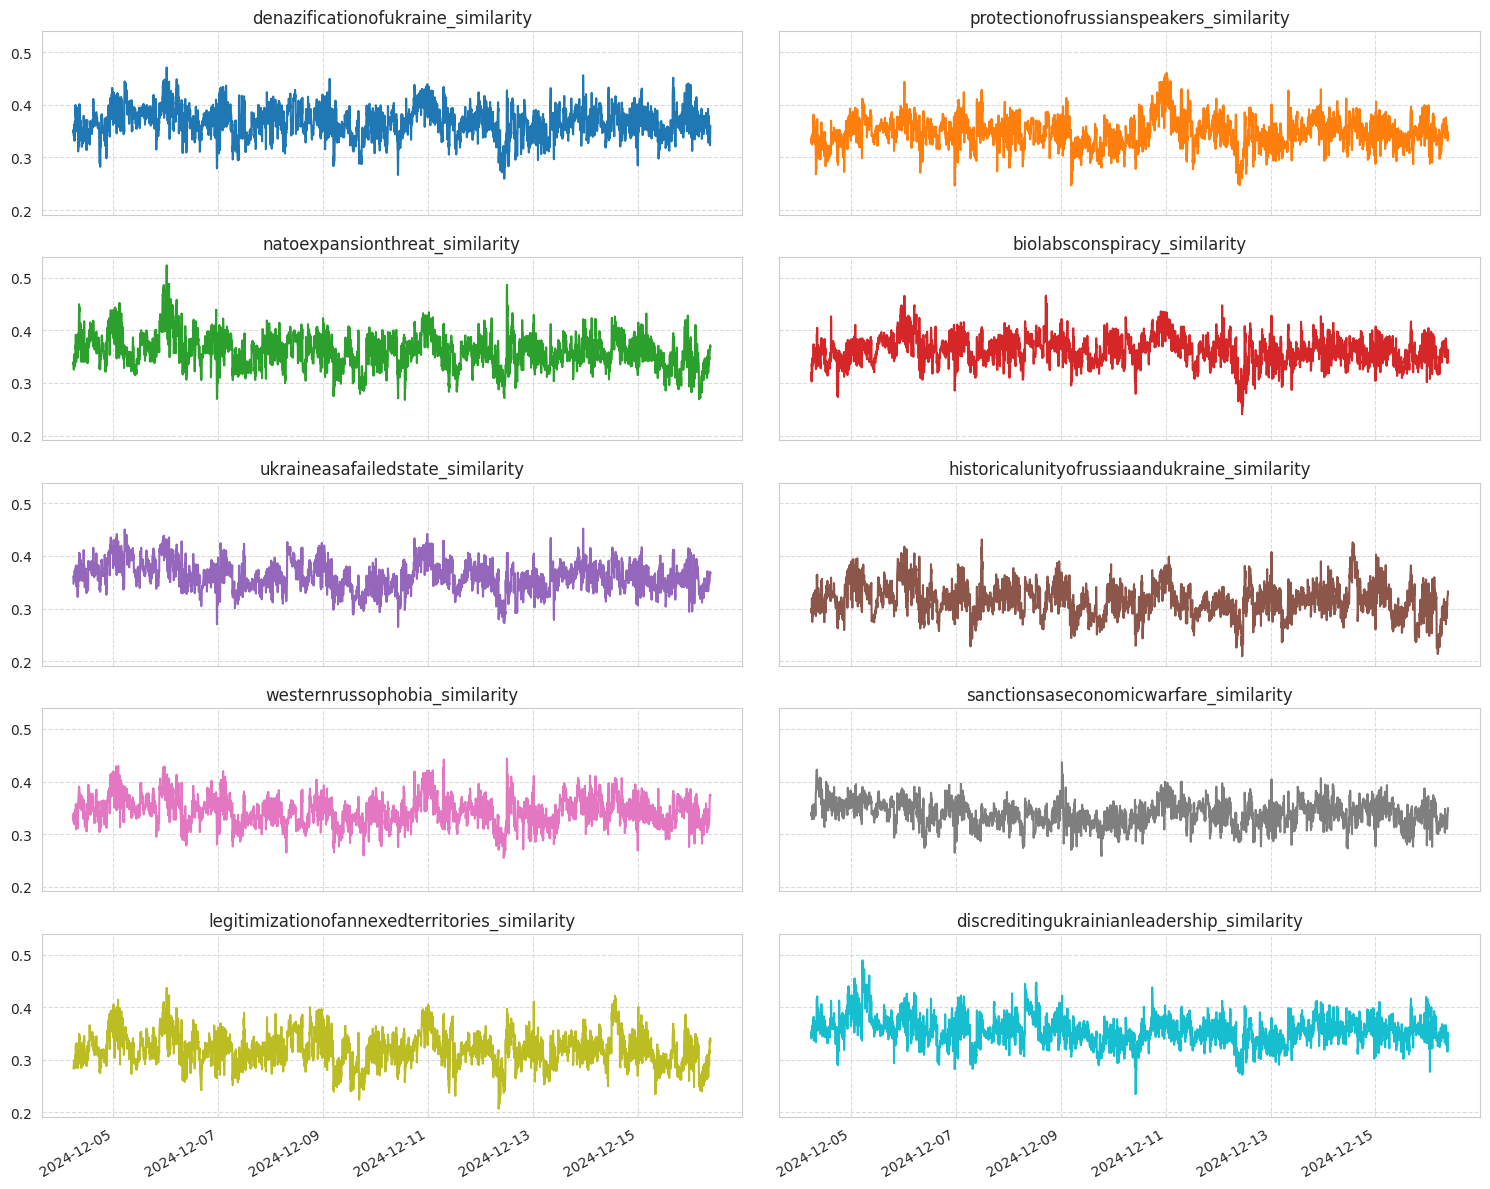

In [44]:
fig, axes = plt.subplots(5, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (density, narrative) in enumerate(zip(densities, narratives)):
    axes[i].plot(density[-3500:], '-', linewidth=1.5, color=plt.cm.tab10(i/10))
    axes[i].set_title(narrative)
    axes[i].grid(True, linestyle='--', alpha=0.7)

fig.autofmt_xdate()
plt.tight_layout()

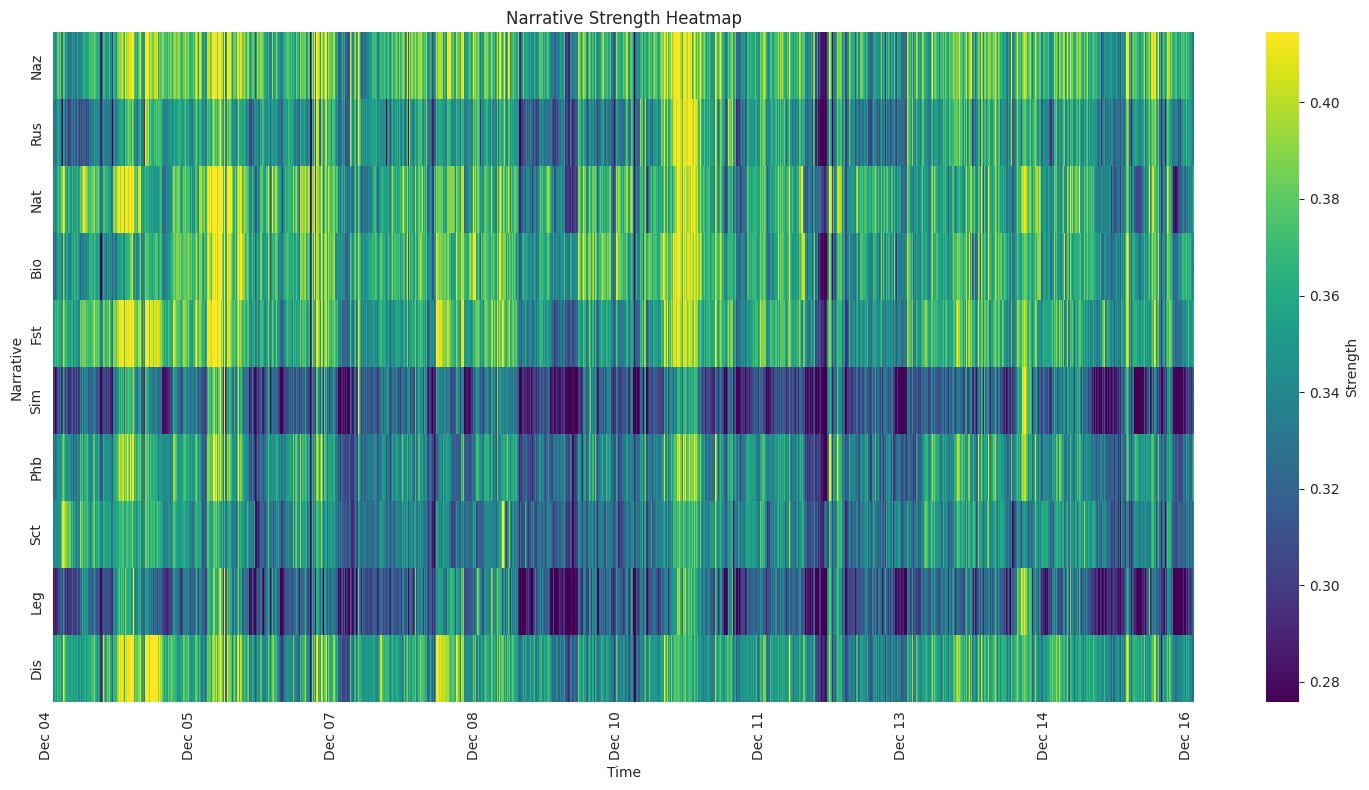

In [52]:
plt.figure(figsize=(15, 8))

# Create a combined DataFrame
all_data = pd.concat([density[-3500:] for density in densities], axis=1)

# Use your custom labels instead of default ones
custom_labels = ['Naz', 'Rus', 'Nat', 'Bio', 'Fst', 'Sim', 'Phb', 'Sct', 'Leg', 'Dis']
all_data.columns = custom_labels

# Create the heatmap with custom colormap if desired
# You could use 'Blues', 'YlGnBu', 'RdBu_r', etc.
heatmap = sns.heatmap(all_data.T, cmap='viridis', robust=True, cbar_kws={'label': 'Strength'})

# Improve timestamp formatting
ax = plt.gca()

# Calculate an appropriate interval to show dates without crowding
data_range = (all_data.index[-1] - all_data.index[0]).total_seconds()
hours_in_data = data_range / 3600
ideal_tick_count = 8

if hours_in_data > 48:  # More than 2 days of data
    date_format = '%b %d'  # Month Day
    step_size = max(1, int(len(all_data) / ideal_tick_count))
elif hours_in_data > 24:  # More than 1 day of data
    date_format = '%b %d %H:00'  # Month Day Hour
    step_size = max(1, int(len(all_data) / ideal_tick_count))
else:  # Less than a day
    date_format = '%H:%M'  # Hour:Minute
    step_size = max(1, int(len(all_data) / ideal_tick_count))

# Set x-ticks and format them
tick_positions = range(0, len(all_data), step_size)
ax.set_xticks([i for i in tick_positions])
ax.set_xticklabels([all_data.index[i].strftime(date_format) for i in tick_positions],
                   rotation=90, ha='right')

plt.title("Narrative Strength Heatmap")
plt.xlabel("Time")
plt.ylabel("Narrative")
plt.tight_layout()